## AWS S3 &  Sentiment Analysis

In this notebook, we will: 

~Download a portion of Amazon Product Reviews from AWS’s Registry of Open Data. 
~Use Pandas, seaborn, and sklearn to clean, transform, and export the data in preparation to train the data for a sentiment analysis algorithm. 
~Take first step in Data Lake formation, using AWS Glue & Athena to catalog metadata & query it using Athena.
~Use Jupyter’s custom magic capabilities to incorporate Athena’s query abilities.

Before you begin, you will need to:

1. Open a free AWS account: https://aws.amazon.com/getting-started/?nc1=f_cc
2. Set up S3 at https://aws.amazon.com/s3
3. Connect Python to your AWS account. Info: https://medium.com/@rogerxujiang/use-s3-storage-on-aws-c4e5ce4fa46e
3. For other project ideas, visit AWS's Registry of Open Data: https://registry.opendata.aws

In [1]:
import boto3
import botocore
import json
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

In [2]:
s3 = boto3.resource('s3')

## Create S3 bucket 

In [4]:
def create_bucket(bucket):
    import logging

    try:
        s3.create_bucket(Bucket=bucket, CreateBucketConfiguration={'LocationConstraint': region})
    except botocore.exceptions.ClientError as e:
        logging.error(e)
        return 'Bucket {0} could not be created.'.format(bucket)
    return 'Created {0} bucket.'.format(bu

In [5]:
create_bucket(bucket)

In [6]:
glue = boto3.client('glue')
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

session = boto3.session.Session()
region = session.region_name

account_id = boto3.client('sts').get_caller_identity().get('Account')
#Replace 'YOURBUCKET' with the bucket you have created in your own
#AWS acccount, above 
bucket ='YOURBUCKET'

amazon_review_bucket = 'amazon-reviews-pds'

pd.set_option('display.max_colwidth', -1)
%matplotlib inline

## Download Amazon Product Reviews

The Amazon Product Review dataset is available on the AWS Open Data Registry.

In [7]:
try:
    s3_resource.Bucket(amazon_review_bucket).download_file('tsv/amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz', 'amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

## Unzip Amazon Video Reviews

In [8]:
!gzip -d amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz

In [9]:
!ls -la

## View raw tsv files.

We will use Pandas read_csv method to load the tsv into a DataFrame. The dataset contains a number of columns associated with each review. For this exercise you will only be concerned with the review_body and star_rating columns. The star_rating is between 1-5 and the review is a free form text field. You will then use the DataFrame's head() method to see the first few rows.

In [10]:
df = pd.read_csv('amazon_reviews_us_Mobile_Electronics_v1_00.tsv', sep='\t', error_bad_lines=False)
df.head()

b'Skipping line 35246: expected 15 fields, saw 22\n'
b'Skipping line 87073: expected 15 fields, saw 22\n'


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,20422322,R8MEA6IGAHO0B,B00MC4CED8,217304173,BlackVue DR600GW-PMP,Mobile_Electronics,5.0,0.0,0.0,N,Y,Very Happy!,"As advertised. Everything works perfectly, I'm very happy with the camera. As a matter of fact I'm going to buy another one for my 2nd car.",2015-08-31
1,US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,137313254,GENSSI GSM / GPS Two Way Smart Phone Car Alarm System for iPhone Android Security,Mobile_Electronics,5.0,0.0,1.0,N,Y,five star,it's great,2015-08-31
2,US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235,iXCC Multi pack Lightning cable,Mobile_Electronics,5.0,0.0,0.0,N,Y,great cables,These work great and fit my life proof case for the iPhone 6,2015-08-31
3,US,4332923,RRB9C05HDOD4O,B00QUFTPV4,221169481,abcGoodefg® FBI Covert Acoustic Tube Earpiece Headset PTT Mic for Motorola Two Way Radio Device Walkie Talkie GP88 300 2000 CT150 P040 PRO1150 SP10 XTN500 2pin,Mobile_Electronics,4.0,0.0,0.0,N,Y,Work very well but couldn't get used to not hearing ...,Work very well but couldn't get used to not hearing anything out of the ear they v were plugged into.,2015-08-31
4,US,44855305,R26I2RI1GFV8QG,B0067XVNTG,563475445,"Generic Car Dashboard Video Camera Vehicle Video Accident Recorder (2.0"" 1080P)",Mobile_Electronics,2.0,0.0,0.0,N,Y,Cameras has battery issues,"Be careful with these products, I have bought several of these cameras and the image is pretty decent but battery doesn't hold any charge!!!!",2015-08-31


## View Data types of the columns

Also some additional information on the data frame.

In [11]:
df.dtypes

marketplace          object 
customer_id          int64  
review_id            object 
product_id           object 
product_parent       int64  
product_title        object 
product_category     object 
star_rating          float64
helpful_votes        float64
total_votes          float64
vine                 object 
verified_purchase    object 
review_headline      object 
review_body          object 
review_date          object 
dtype: object

In [12]:
#more info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104852 entries, 0 to 104851
Data columns (total 15 columns):
marketplace          104852 non-null object
customer_id          104852 non-null int64
review_id            104852 non-null object
product_id           104852 non-null object
product_parent       104852 non-null int64
product_title        104852 non-null object
product_category     104852 non-null object
star_rating          104850 non-null float64
helpful_votes        104850 non-null float64
total_votes          104850 non-null float64
vine                 104850 non-null object
verified_purchase    104850 non-null object
review_headline      104848 non-null object
review_body          104849 non-null object
review_date          104850 non-null object
dtypes: float64(3), int64(2), object(10)
memory usage: 12.0+ MB


In [13]:
df.shape #(rows, columns)

(104852, 15)

## Create a new DataFrame for only columns needed

You will keep only the review_body & star_rating fields, using the loc method to access just what you need. You also will filter out neutral reviews, those with a 3 star rating, so the positive vs. negative reviews are more definitive.

In [14]:
df = df.loc[:, ['review_body', 'star_rating']]
df = df.query('star_rating != 3.0')
df.head()

,review_body,star_rating
0,"As advertised. Everything works perfectly, I'm very happy with the camera. As a matter of fact I'm going to buy another one for my 2nd car.",5.0
1,it's great,5.0
2,These work great and fit my life proof case for the iPhone 6,5.0
3,Work very well but couldn't get used to not hearing anything out of the ear they v were plugged into.,4.0
4,"Be careful with these products, I have bought several of these cameras and the image is pretty decent but battery doesn't hold any charge!!!!",2.0


In [15]:
df.shape

(95132, 2)

## Add new column sentiment based on star_rating. 

We will use the apply method to apply a function to each row in the DataFrame adding a new column sentiment. This will make it easier to visualize the data.

In [17]:
def get_sentiment(value):
    if value > 3:
        return 1
    else:
        return 0

In [18]:
df['sentiment'] = df['star_rating'].apply(get_sentiment)


In [19]:
df.head()


,review_body,star_rating,sentiment
0,"As advertised. Everything works perfectly, I'm very happy with the camera. As a matter of fact I'm going to buy another one for my 2nd car.",5.0,1
1,it's great,5.0,1
2,These work great and fit my life proof case for the iPhone 6,5.0,1
3,Work very well but couldn't get used to not hearing anything out of the ear they v were plugged into.,4.0,1
4,"Be careful with these products, I have bought several of these cameras and the image is pretty decent but battery doesn't hold any charge!!!!",2.0,0


## Basic Data Cleaning

There are a number of ways to clean the dataset you are working with. You will go through a few exercises looking at the data and performing actions based on the results to cleanse the data. The first thing you want to do is look at the unique star_rating values. You will notice there are reviews with a nan rating so we will want to remove those using the dropna method.

We can visualize the counts to quickly see the breakout by star_rating. For that you will be using seaborn.

Next we want to de-duplicate the rows. It is necessary to remove duplicates in order to get unbiased results. Checking duplicates based on review_body and star_rating. If all values are equal then we will remove those records.

At this time we can also transform the 'review_body' from its regular form, with capital letters to the pure lowercase text. We can also see below we have ratings with a nan value meaning no star_rating was giving for the review. We will drop the nan reviews as well to clean up the data set.

In [20]:
df.star_rating.unique()


array([ 5.,  4.,  2.,  1., nan])

In [21]:
df.dropna(inplace=True)


## Visualize the review counts¶


5.0    52197
4.0    18063
1.0    17571
2.0    7298 
Name: star_rating, dtype: int64


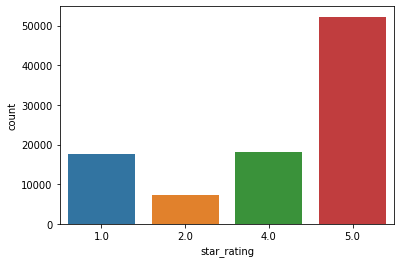

In [22]:
print(df['star_rating'].value_counts())
sns.countplot(x='star_rating', data=df)

## Drop duplicates and set proper data types¶


In [23]:
import string
df = df.drop_duplicates(subset={'review_body', 'star_rating'})

df.dropna(inplace=True)
df.loc[:, 'star_rating'] = df['star_rating'].astype(int)
df.loc[:, 'review_body'] = df['review_body'].astype(str).str.lower()
df.head()

,review_body,star_rating,sentiment
0,"as advertised. everything works perfectly, i'm very happy with the camera. as a matter of fact i'm going to buy another one for my 2nd car.",5,1
1,it's great,5,1
2,these work great and fit my life proof case for the iphone 6,5,1
3,work very well but couldn't get used to not hearing anything out of the ear they v were plugged into.,4,1
4,"be careful with these products, i have bought several of these cameras and the image is pretty decent but battery doesn't hold any charge!!!!",2,0


1    67999
0    24720
Name: sentiment, dtype: int64


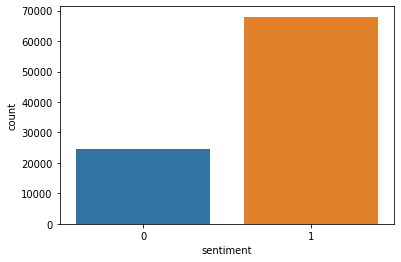

In [24]:
print(df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df)

## Python Wordcloud Visualization 

Another visualization technique you can use to see what words stand out in the data set is to build a Wordcloud visualization. First, we will use pip to install the library and then build a simple function to plot the words.

In [ ]:
!python -m pip install wordcloud

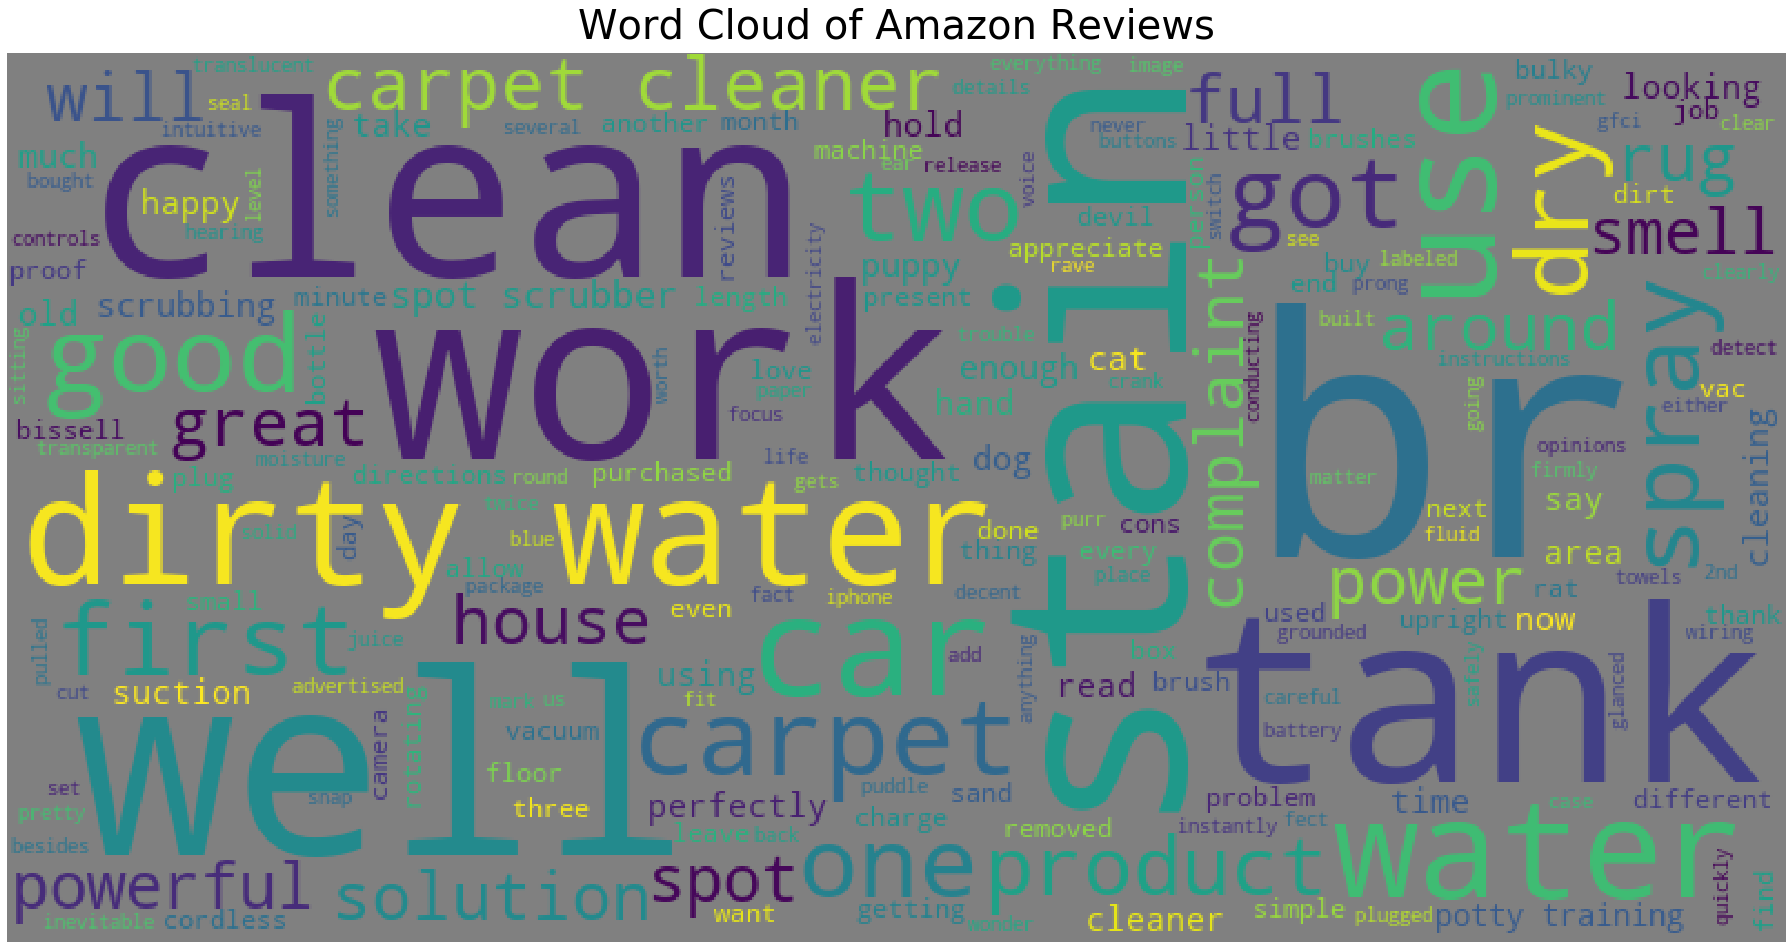

In [26]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=150, figure_size=(25.0,15.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color='gray',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 50,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df['review_body'], title="Word Cloud of Amazon Reviews")

## Discover

In [27]:
import string

## Number of words in the text ##
df["num_words"] = df["review_body"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
df["num_unique_words"] = df["review_body"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
df["num_chars"] = df["review_body"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
df["num_stopwords"] = df["review_body"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
df["num_punctuations"] = df['review_body'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Average length of the words in the text ##
df["mean_word_len"] = df["review_body"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [28]:
df.describe()

,star_rating,sentiment,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len
count,92719.000000,92719.000000,92719.000000,92719.000000,92719.000000,92719.000000,92719.000000,92719.000000
mean,3.819832,0.733388,64.005576,45.477378,342.555916,31.366559,12.048156,4.377902
std,1.586057,0.442190,94.453394,46.753421,519.264770,45.612489,24.735220,0.697857
min,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,22.000000,20.000000,117.000000,10.000000,3.000000,4.020408
50%,5.000000,1.000000,36.000000,31.000000,192.000000,18.000000,6.000000,4.297872
75%,5.000000,1.000000,72.000000,55.000000,380.000000,36.000000,12.000000,4.609195
max,5.000000,1.000000,2906.000000,971.000000,16009.000000,1429.000000,1016.000000,55.000000


In [29]:
## Truncate some extreme values for better visuals, think about balancing positive vs negative reviews ##
df = df.query('num_words <= 500 and num_punctuations < 500')

1    67410
0    24590
Name: sentiment, dtype: int64


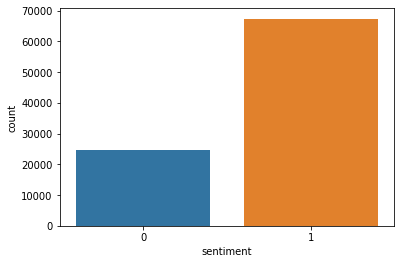

In [30]:
print(df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df)

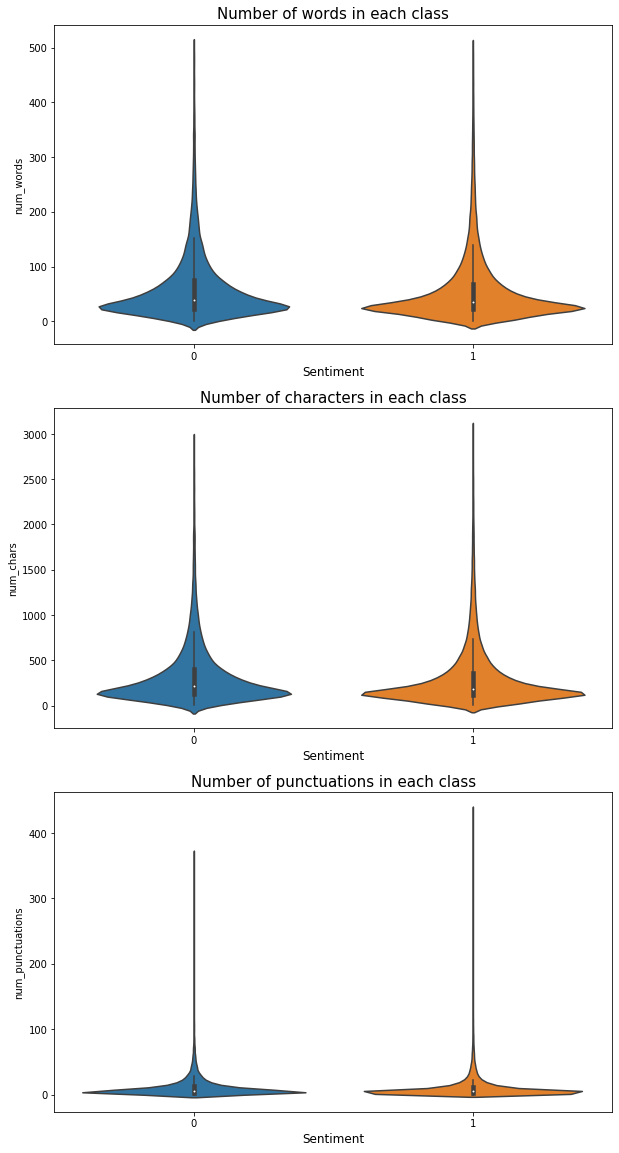

In [31]:
f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.violinplot(x='sentiment', y='num_words', data=df, ax=axes[0])
axes[0].set_xlabel('Sentiment', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.violinplot(x='sentiment', y='num_chars', data=df, ax=axes[1])
axes[1].set_xlabel('Sentiment', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.violinplot(x='sentiment', y='num_punctuations', data=df, ax=axes[2])
axes[2].set_xlabel('Sentiment', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

## Handling imbalanced datasets

Here you can see we have a larger number of positive samples vs. negative ones. There are a number of techniques to balance this dataset out and the two most popular approaches are to either under-sample or over-sample. With under sampling you remove rows to balance the dataset out and in over sampling you can duplicate entries in the dataset which could lead to overfitting. This discussion is beyond the scope of this lab. You will under sample the data to balance the dataset.

1    24590
0    24590
Name: sentiment, dtype: int64


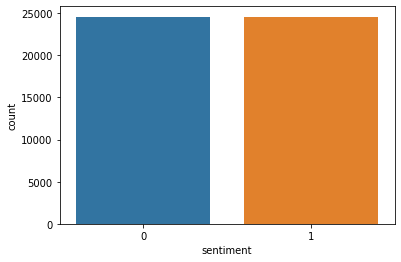

In [32]:
from sklearn.utils import resample

positive = df[df['sentiment']==1]
negative = df[df['sentiment']==0]

positive_downsampled = resample(positive,
                                replace = False, # sample without replacement
                                n_samples = len(negative), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([positive_downsampled, negative])

# checking counts
print(downsampled['sentiment'].value_counts())
sns.countplot(x='sentiment', data=downsampled)

## Export datasets

In [33]:
import csv 

file_name = 'reviews.csv'
final_df = downsampled.loc[:, ['review_body', 'star_rating', 'sentiment']]
final_df['review_body'] = downsampled['review_body'].astype('str')
final_df.to_csv("reviews.csv", index=False, header=False, quoting=csv.QUOTE_ALL, escapechar='\\', doublequote=False)

## Unlabeled Data

We will also create a dataset here with the reviews only. This will simulate not having labelled data for training.

In [34]:
gt_df = downsampled.loc[:, ['review_body']]
gt_df.to_csv("groundtruth.csv", index=False, header=True)

In [35]:
unlabeled_df = pd.read_csv('groundtruth.csv', error_bad_lines=False)
unlabeled_df.head()

,review_body
0,"just what i wanted, fits my motorola razor hd max. comfortable and easy to use. i would recommend this product to friends."
1,"very good product, got merchandise when they said we would. happy with purchase and was very easy to install. liked that the certificate of authenticity came with the product."
2,"this cable is thick and is high quality. works great like it should with no errors or incompatibility. great price, great product, highly and strongly recommend this for apple products."
3,"for the price, this is a great little radio. not the strongest transmitting power but good and its super clear on the receiving end. no issues."
4,"i have the old version of this deck, the kdc-mp438u. i have had it in different cars for 5 years now. still works great."


## Upload to S3

In [ ]:
s3_resource.Bucket(bucket).Object(os.path.join('raw', file_name)).upload_file(file_name)
s3_resource.Bucket(bucket).Object(os.path.join('unlabeled', 'groundtruth.csv')).upload_file('groundtruth.csv')

## List S3 Bucket Contents
Now that we have uploaded objects to our S3 bucket we can view the contents of the bucket as well through the SDK.

In [ ]:
paginator = s3.get_paginator('list_objects_v2')
for result in paginator.paginate(Bucket=bucket):
    if result.get('Contents') is not None:
        for files in result.get('Contents'):
            if not files.get('Key') == "":
                print(files.get('Key'))

## Create text, train, and validate datasets for training

Depending on the framework you are leveraging in your AI/ML workloads you may decide to split the data into test, train, and validate splits before uploading to S3. You can leverage some built in functions in the sklearn package to do the split. 


In [39]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(final_df, test_size=0.2, random_state=0)
train, validate = train_test_split(train, test_size=0.2, random_state=0)

print(f'Number of training examples: {len(train.index)}')
print(f'Number of validation examples: {len(validate.index)}')
print(f'Number of testing examples: {len(test.index)}')

Number of training examples: 31475
Number of validation examples: 7869
Number of testing examples: 9836


In [40]:
train.to_csv("train.csv", index=False, header=False, quoting=csv.QUOTE_NONE, escapechar='\\')
test.to_csv("test.csv", index=False, header=False, quoting=csv.QUOTE_NONE, escapechar='\\')
validate.to_csv("validate.csv", index=False, header=False, quoting=csv.QUOTE_NONE, escapechar='\\')

## Upload to S3
We'll upload the splits created above to S3

In [41]:
s3_resource.Bucket(bucket).Object(os.path.join('data', 'train.csv')).upload_file('train.csv')
s3_resource.Bucket(bucket).Object(os.path.join('data', 'test.csv')).upload_file('test.csv')
s3_resource.Bucket(bucket).Object(os.path.join('data', 'validate.csv')).upload_file('validate.csv')

## Democratizing Data: Data Lake Step 1

You may determine that you want to make this dataset available to your lab or team to give them the ability to perform their own research on this same dataset. You can utilize a number of services in the AWS Data Lakes & Analytics group to do so. This is the start of building out a Data Lake on AWS. We will start by cataloging the raw data in the Glue Data Catalog which is a Hive compliant metadata repository.


## Create the AWS Glue Catalog Database

When you define a table in the AWS Glue Data Catalog, you add it to a database. A database is used to organize tables in AWS Glue. You can organize your tables using a crawler or using the AWS Glue console. A table can be in only one database at a time.

There is a central Glue Catalog for each AWS account. When creating the database you will use your account id declared above as account_id

In [42]:
def create_database(glue_client, account_id, database_name, description):
    """Create the specified Glue database if it does not exist"""
    try:
        glue_client.get_database(
            CatalogId=account_id,
            Name=database_name
        )
    except glue_client.exceptions.EntityNotFoundException:
        print("Creating database: %s" % database_name)
        glue_client.create_database(
            CatalogId=account_id,
            DatabaseInput={
                'Name': database_name,
                'Description': description
            }
        )


In [43]:
database_name = 'reviews'
create_database(glue, account_id, database_name, 'Database for Amazon Reviews')

## Create the Raw table in Glue.

When you define a table in AWS Glue, you also specify the value of a classification field that indicates the type and format of the data that's stored in that table. If a crawler creates the table, these classifications are determined by either a built-in classifier or a custom classifier. If you create a table manually in the console or by using an API, you specify the classification when you define the table. For more information about creating a table using the AWS Glue console, see Working with Tables on the AWS Glue Console.

In [ ]:
location = 's3://{0}/raw/'.format(bucket)
raw_table_name = 'raw'

response = glue.create_table(
    CatalogId=account_id,
    DatabaseName=database_name,
    TableInput={
        'Name': raw_table_name,
        'Description': 'Raw Amazon Mobile Products reviews',
        'StorageDescriptor': {
            'Columns': [                
                {
                    'Name': 'review_body',
                    'Type': 'string',
                    'Comment': 'Review text of from the review'
                },         
                {
                    'Name': 'star_rating',
                    'Type': 'float',
                    'Comment': 'Star rating of from the review'
                },
                {
                    'Name': 'sentiment',
                    'Type': 'tinyint',
                    'Comment': 'Sentiment based on the star rating of from the review'
                }
            ],
            'Location': location,
            'InputFormat': 'org.apache.hadoop.mapred.TextInputFormat',
            'OutputFormat': 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat',
            'SerdeInfo': {
                'SerializationLibrary': 'org.apache.hadoop.hive.serde2.OpenCSVSerde',
                'Parameters': {
                    'escapeChar': '\\',
                    'separatorChar': ',',
                    'serialization.format': '1'
                }
            },
        },
        'TableType': 'EXTERNAL_TABLE',
        'Parameters': {
            'classification': 'csv'
        }
    }
)



## Query Raw Data with Athena

To see the raw reviews we will be installing a python library for querying the data in the Glue Data Catalog with Athena. More information about PyAthena or available ANSI SQL and DDL commands with Athena

In [ ]:
!pip install PyAthena

In [45]:
from pyathena import connect
from pyathena.util import as_pandas

cursor = connect(region_name=region, s3_staging_dir='s3://{0}/temp'.format(bucket)).cursor()
cursor.execute('select * from {0}.{1} limit 10'.format(database_name, raw_table_name))

df = as_pandas(cursor)
df.head(5)

,review_body,star_rating,sentiment
0,"i bought this to amplify the sad and barely audible speaker on the ipad 2, but it doesn't seem to work. however, it works great with my ipod. it's light and a little longer than a standard computer mouse and it has a lot of features packed into a compact size, with the capacity for fm, an sd card slot and auxiliary input. the sound quality isn't exceptional, but it's clear.",4.0,1
1,i love it. use it all of the time. easy to use. excellent buy for the price.,5.0,1
2,love the pouch! fits snug and doesn't move. i don't like to run in nikes so this is a great alternative and it works with my running shoes. i would definitely recommend to others!,5.0,1
3,good seller. quick delivery and product as promised. thanks,5.0,1
4,"i have used my pink ipod cover for several months. it's very sturdy and has a foamy interior to cushion the ipod. i dropped it once and there was no damage to the ipod. it fits perfect! i looked for headphones to match(at walmart)and the closest in the same color was the marshmallows, i do not recommend these. they don't fit comfortably in your ears and are very akward.",5.0,1


In [46]:
cursor.execute('select count(1) as count, star_rating from {0}.{1} group by star_rating'.format(database_name, raw_table_name))

df = as_pandas(cursor)
df

,count,star_rating
0,6440,4.0
1,18154,5.0
2,7240,2.0
3,17354,1.0


##  SQL Magic Commands in Jupyter Notebook

(Optional) You can use the built-in functionality in Jupyter to create shortcut magic commands to fit your needs. Here we will use the pyathena library like above to query the review data, but this time we will encapsulate the call in the Jupyter magic command.

In [47]:
import pyathena
from pyathena.util import as_pandas

from IPython.core import magic_arguments
from IPython.core.magic import cell_magic, Magics, magics_class


def query_athena(sql, region_name, s3_staging_dir):
    cursor = pyathena.connect(
        region_name=region_name,
        s3_staging_dir="{}".format(s3_staging_dir)).cursor()
    cursor.execute(sql)
    return cursor

@magics_class
class AthenaMagics(Magics):
    s3_staging_dir = None
    region_name = None

    
    def parse_args(self, line):
        args = magic_arguments.parse_argstring(self.athena, line)

        # s3 staging directory
        if args.s3_staging_dir is None and self.s3_staging_dir is None:
            raise ValueError("s3_staging_dir for Athena should be set")
        if args.s3_staging_dir is not None:
            self.s3_staging_dir = args.s3_staging_dir
 
        # region name
        if args.region_name is None and self.region_name is None:
            raise ValueError("region_name for Athena should be set")
        if args.region_name is not None:
            self.region_name = args.region_name
 
    @cell_magic
    @magic_arguments.magic_arguments()
    @magic_arguments.argument('--s3_staging_dir', '-s',
        help='s3 path required by athena for writing query results (e.g. s3://your/staging/dir)'
    )
    @magic_arguments.argument('--region_name', '-r',
        help='aws region name (e.g. us-west-2)'
    )
    def athena(self, line='', cell=None):
        self.parse_args(line)
        cursor = query_athena(cell, self.region_name, self.s3_staging_dir)
        return as_pandas(cursor)

    
ip = get_ipython()
ip.register_magics(AthenaMagics)

In [ ]:
print(region)
print("s3://{0}/temp".format(bucket))

## Query Glue Data Catalog with Athena Magic
Now that the magic is registered you can use the %%athena magic to query data registered in your Glue Data Catalog. Replace the {{region}} and {{bucket/temp}} with your region and bucket variable values.

Example:
%%athena -r us-west-2 -s s3://'YOURBUCKET'/temp

In [50]:
%%athena -r {{region}} -s {{bucket/temp}}
select * 
select * 
from reviews.raw limit 10;

,review_body,star_rating,sentiment
0,"i bought this to amplify the sad and barely audible speaker on the ipad 2, but it doesn't seem to work. however, it works great with my ipod. it's light and a little longer than a standard computer mouse and it has a lot of features packed into a compact size, with the capacity for fm, an sd card slot and auxiliary input. the sound quality isn't exceptional, but it's clear.",4.0,1
1,i love it. use it all of the time. easy to use. excellent buy for the price.,5.0,1
2,love the pouch! fits snug and doesn't move. i don't like to run in nikes so this is a great alternative and it works with my running shoes. i would definitely recommend to others!,5.0,1
3,good seller. quick delivery and product as promised. thanks,5.0,1
4,"i have used my pink ipod cover for several months. it's very sturdy and has a foamy interior to cushion the ipod. i dropped it once and there was no damage to the ipod. it fits perfect! i looked for headphones to match(at walmart)and the closest in the same color was the marshmallows, i do not recommend these. they don't fit comfortably in your ears and are very akward.",5.0,1
5,"replaced the 6x8 speakers in my f-150 and it transformed the system. the stock system is the single cd am/fm head unit, sirius radio, and the four 6x8 speakers. also, there is an ipod line-in connection on the top of the dash. the sirius radio is free for six months and the receiver is made to work with the stock head unit, not a simple plug-in for a replacement front end. my hope was the new speakers would provide some improvement over the lackluster performance of the stock speakers. i replaced the front speakers first and faded front to rear to compare with the stock speakers. the boston acoustic sl80 speakers are far more musical and accurate. you can hear the qualities of the individual instruments and voices. the highs are sweet and the bass is amazing from such a small driver. i could easily live with the system now for as long as i own the truck. i'm sure the sl80 speakers are now the strongest link in the chain (replacing the weakest link) and could benefit from upgrading the rest of the system, but the stock cd/radios are better quality than they used to be. if i were to upgrade any further, it would probably mean replacing everything else in order to add a subwoofer because of compatibility with the head unit. if it comes to that, i hope i could utilize the sirius antenna integrated in the roof and keep the line-in connection in the dash for the ipod.",5.0,1
6,amazing for the price... will not tither.,5.0,1
7,"i bought this case for my garmin. i keep my garmin in my car in the storage area by the arm rest and this case is the perfect case for protecting it; plus, the case is very well made. i am very pleased with this purchase and would recommend it to everyone.",5.0,1
8,"this system is ok. headphones are a bit on the cheaper side, but it is easy to use and puts out loud sound. i simply use it to go walking. it's nice for the price!",4.0,1
9,"i have used four products in the past ranging from $50 to $200. the group5 wp7 is currently the best i have used.- superior night time low light quality. even without streets lights, just headlights alone the camera captures great images.- clearly captures license plate reading from car in front, even at night. i have yet to see a dash camera that can do this.- easy to use manual. with on screen guidance, this makes operating the camera while driving much easier than other cameras i have used. because button guidance is on screen the camera doesn't need as much buttons as other cameras i have used.",5.0,1


You have successfully completed this lab!!!!
In this lab you learned to store and retrieve objects with S3, do data manipulation with a number of tools in python like pandas, seaborn, and sklearn, and register and query data in AWS to start building out a data lake to democratize access to datasets for machine learning.


Source: https://github.com/aws-samples/aws-research-workshops/blob/master/notebooks/escience_series/using_s3_and_analytics.ipynb